In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Isolation Forest algorythm for outlier detection.
from sklearn.ensemble import IsolationForest
from matplotlib.lines import Line2D

# Importing the necessary functions from the file they are stored
from utils import find_outliers_zscore, find_outliers_modified_zscore, find_outliers_iqr, get_common_outliers

# Display all columns of the DataFrame 
pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv("CreditCardChurn.csv")

In [3]:
df.shape

(10127, 23)

In [4]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


### Dropped columns:
- ### Average open to buy ratio(Correlation with Credit Limit almost 1, dropped from the beggining to reduce clutter)
- ### Naive Bayes classifier columns(Were made by the author of the dataset, not needed)

In [5]:
df.drop(columns=['CLIENTNUM','Avg_Open_To_Buy','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

### There are no NaN values

In [6]:
df.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [7]:
df.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


# Univariate Analysis

## Categorical Columns EDA

### Target variable is imbalanced. We may need to use some techniques to balance it while predicting churn.

Attrition Flag Values:
Existing Customer: 8500
Attrited Customer: 1627


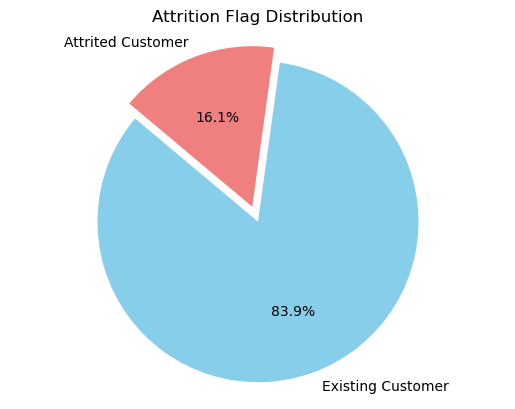

In [8]:
labels = df['Attrition_Flag'].value_counts().index
sizes = df['Attrition_Flag'].value_counts().values
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  

print("Attrition Flag Values:")

for label, size in zip(labels, sizes):
    print(f"{label}: {size}")

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Attrition Flag Distribution')
plt.axis('equal')

plt.show()

Female: 5358
Male: 4769


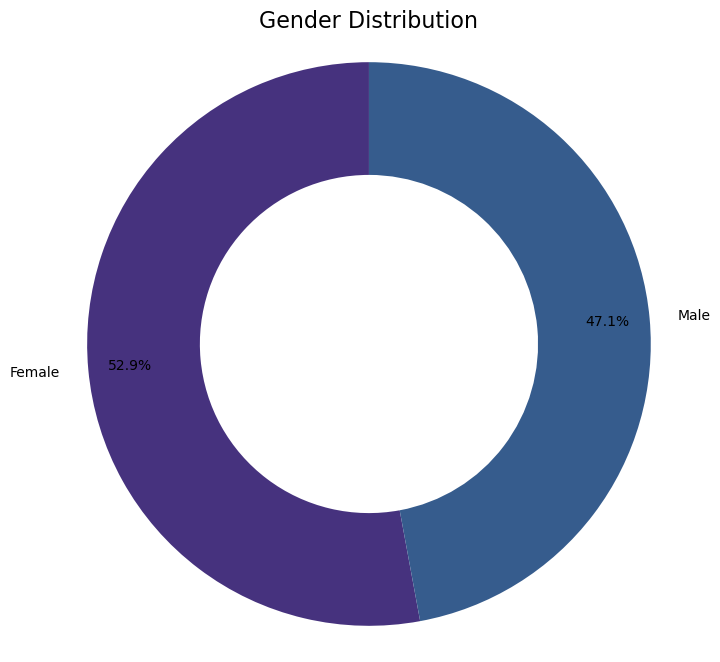

In [9]:
df['Gender'].replace({"F":"Female", "M":"Male"}, inplace=True)

labels = df['Gender'].value_counts().index
sizes = df['Gender'].value_counts().values

for label, size in zip(labels, sizes):
    print(f"{label}: {size}")

plt.figure(figsize=(8, 8))
gender_counts = df['Gender'].value_counts()
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct=lambda p: '{:.1f}%'.format(p),
    startangle=90,
    colors=sns.color_palette("viridis"),
    wedgeprops=dict(width=0.4),
    pctdistance=0.85  
)
plt.title('Gender Distribution', fontsize=16)
plt.axis('equal')  
plt.show()


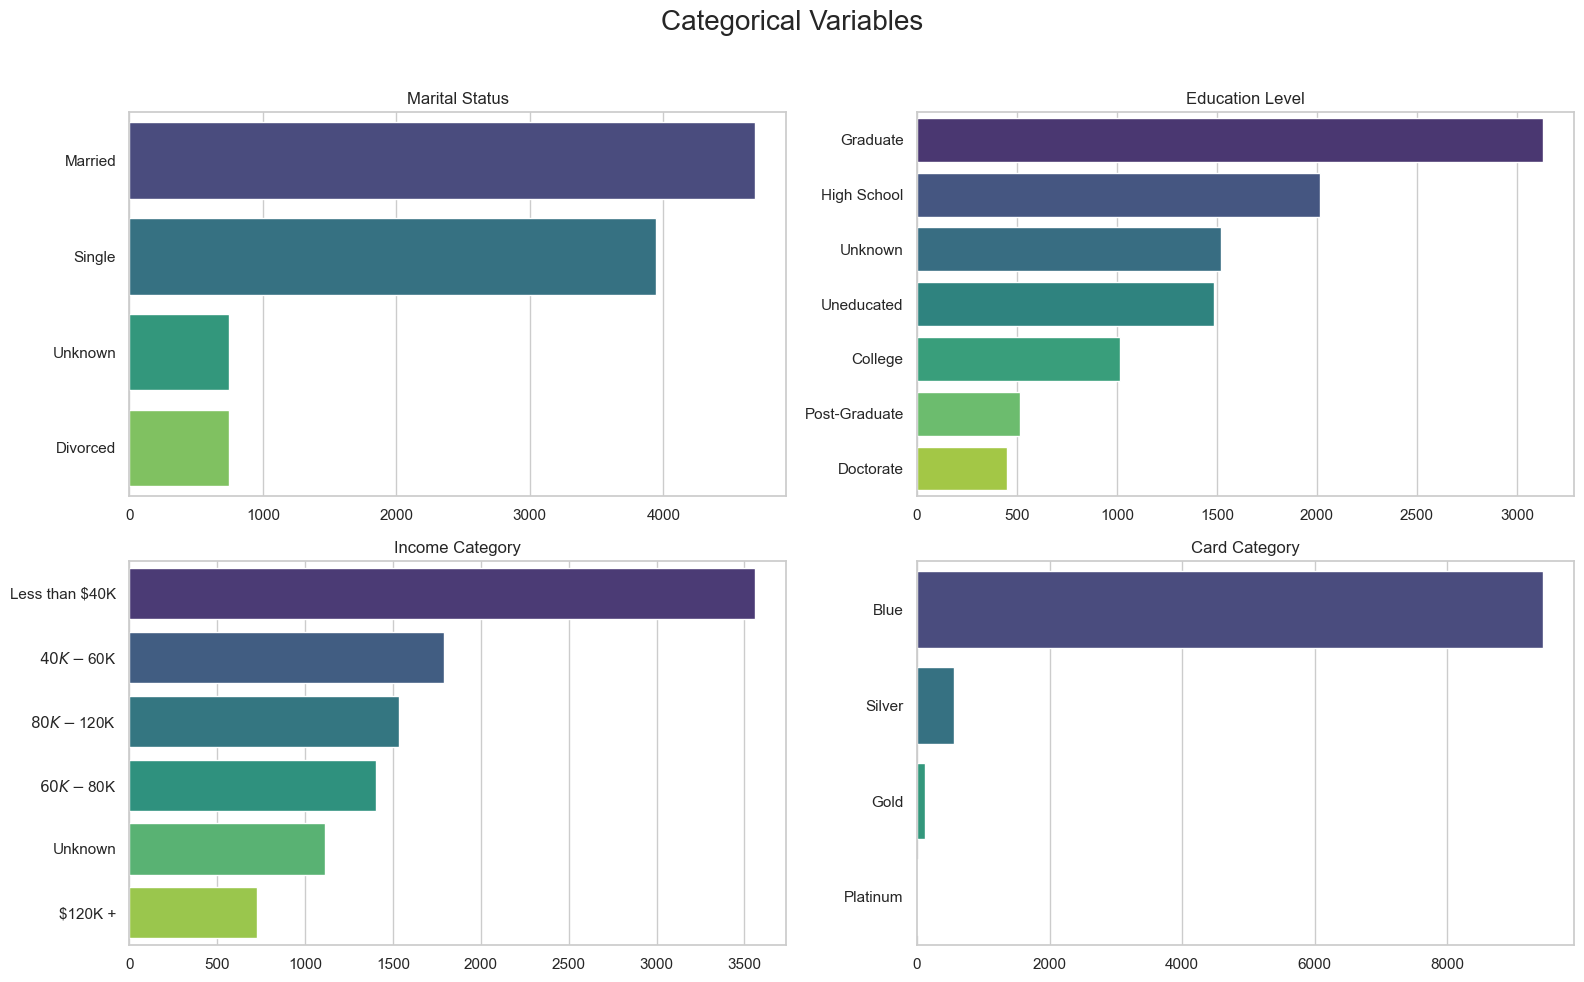

In [10]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a 2x2 dashboard-like layout with a longer horizontal layout
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Title for the entire dashboard
fig.suptitle('Categorical Variables', fontsize=20)

# Marital Status - Horizontal Bar Plot (Sorted)
marital_sorted_values = df['Marital_Status'].value_counts().sort_values(ascending=False)
sns.barplot(x=marital_sorted_values, y=marital_sorted_values.index, palette='viridis', ax=axs[0, 0])
axs[0, 0].set_title('Marital Status')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('')

# Education Level - Horizontal Bar Plot (Sorted)
education_sorted_values = df['Education_Level'].value_counts().sort_values(ascending=False)
sns.barplot(x=education_sorted_values, y=education_sorted_values.index, palette='viridis', ax=axs[0, 1])
axs[0, 1].set_title('Education Level')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('')

# Income Category - Horizontal Bar Plot (Sorted)
income_sorted_values = df['Income_Category'].value_counts().sort_values(ascending=False)
sns.barplot(x=income_sorted_values, y=income_sorted_values.index, palette='viridis', ax=axs[1, 0])
axs[1, 0].set_title('Income Category')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('')

# Card Category - Horizontal Count Plot (Sorted)
card_sorted_values = df['Card_Category'].value_counts().sort_values(ascending=False)
sns.barplot(y=card_sorted_values.index, x=card_sorted_values, palette='viridis', ax=axs[1, 1])
axs[1, 1].set_title('Card Category')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Numerical Columns EDA

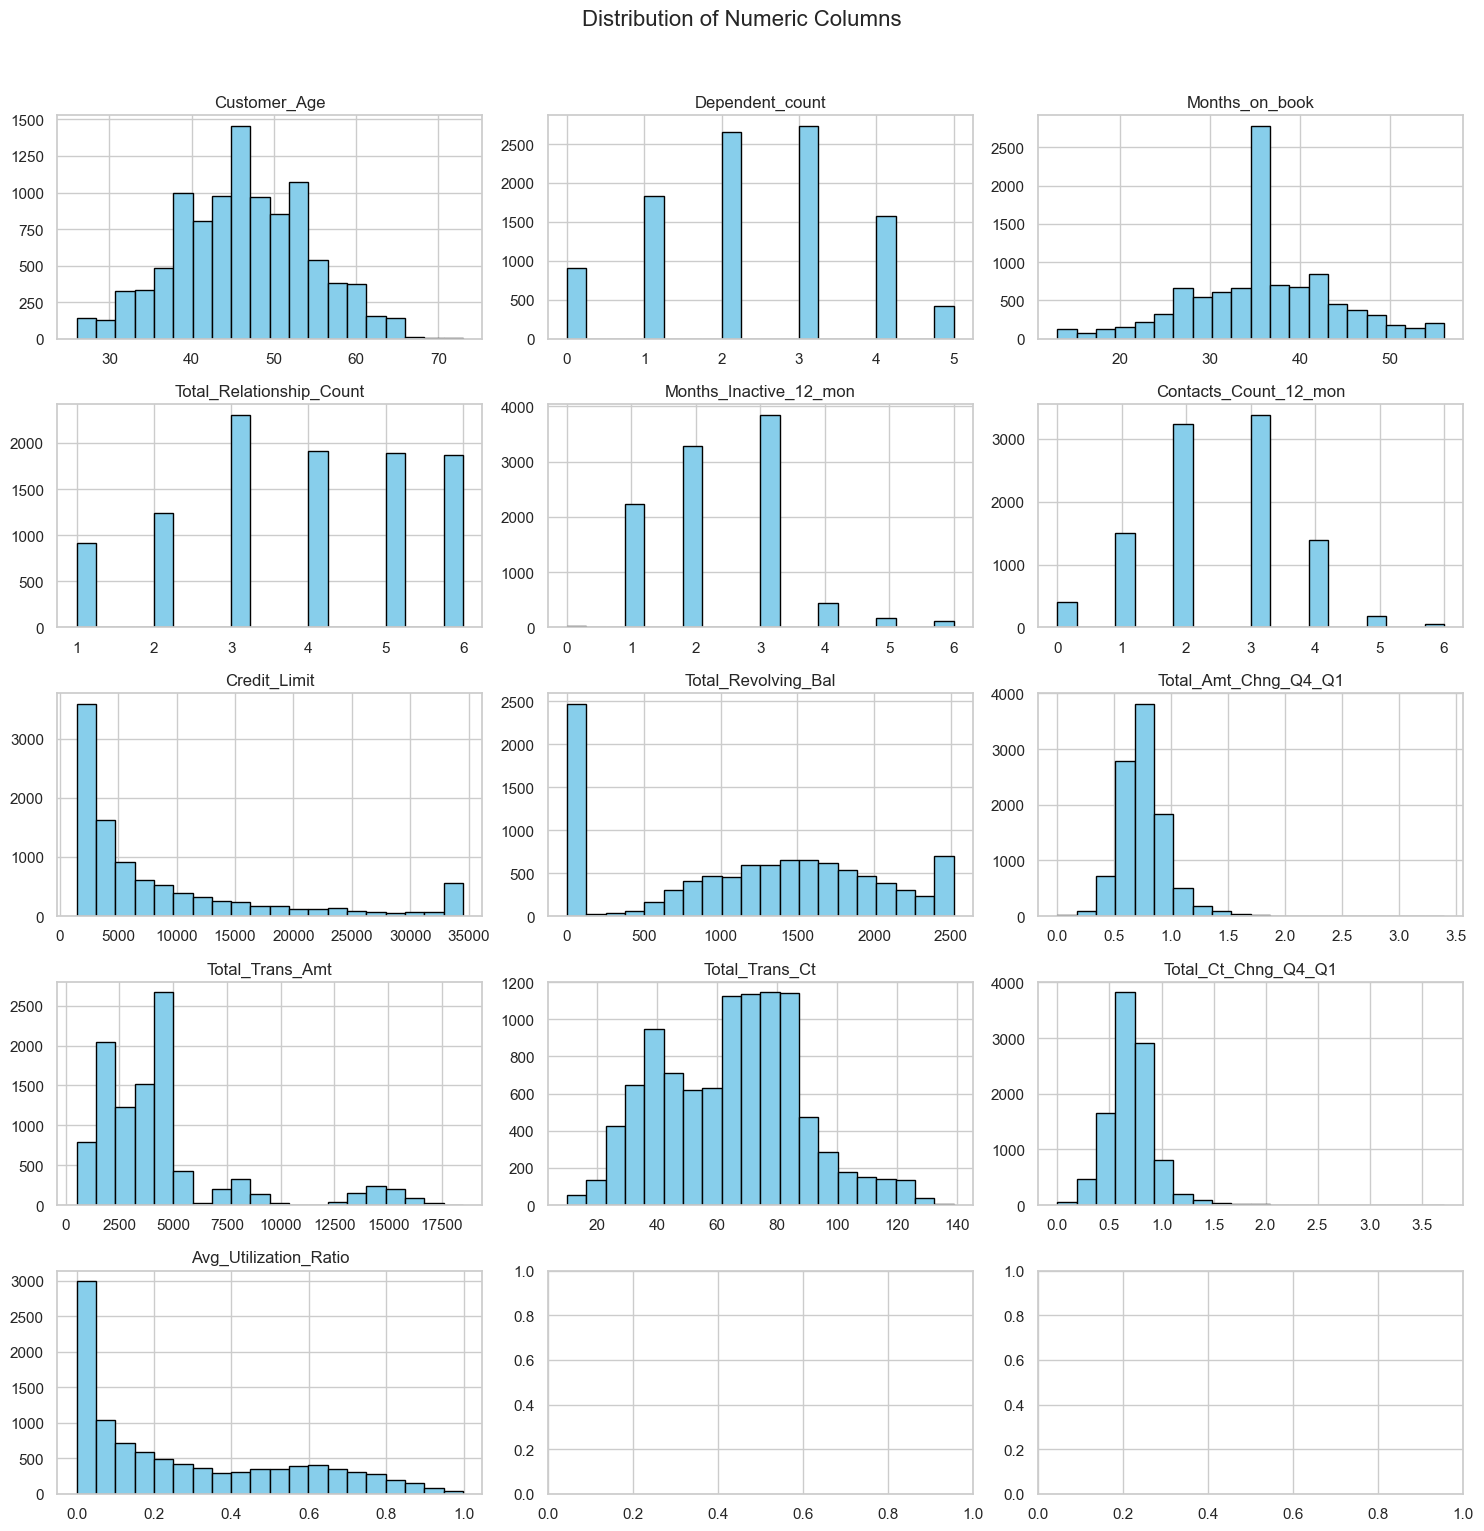

In [11]:
numeric_columns = [
    'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
    'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'
]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)

fig.suptitle('Distribution of Numeric Columns', fontsize=16, y=1.02, ha='center')

plt.tight_layout()
plt.show()

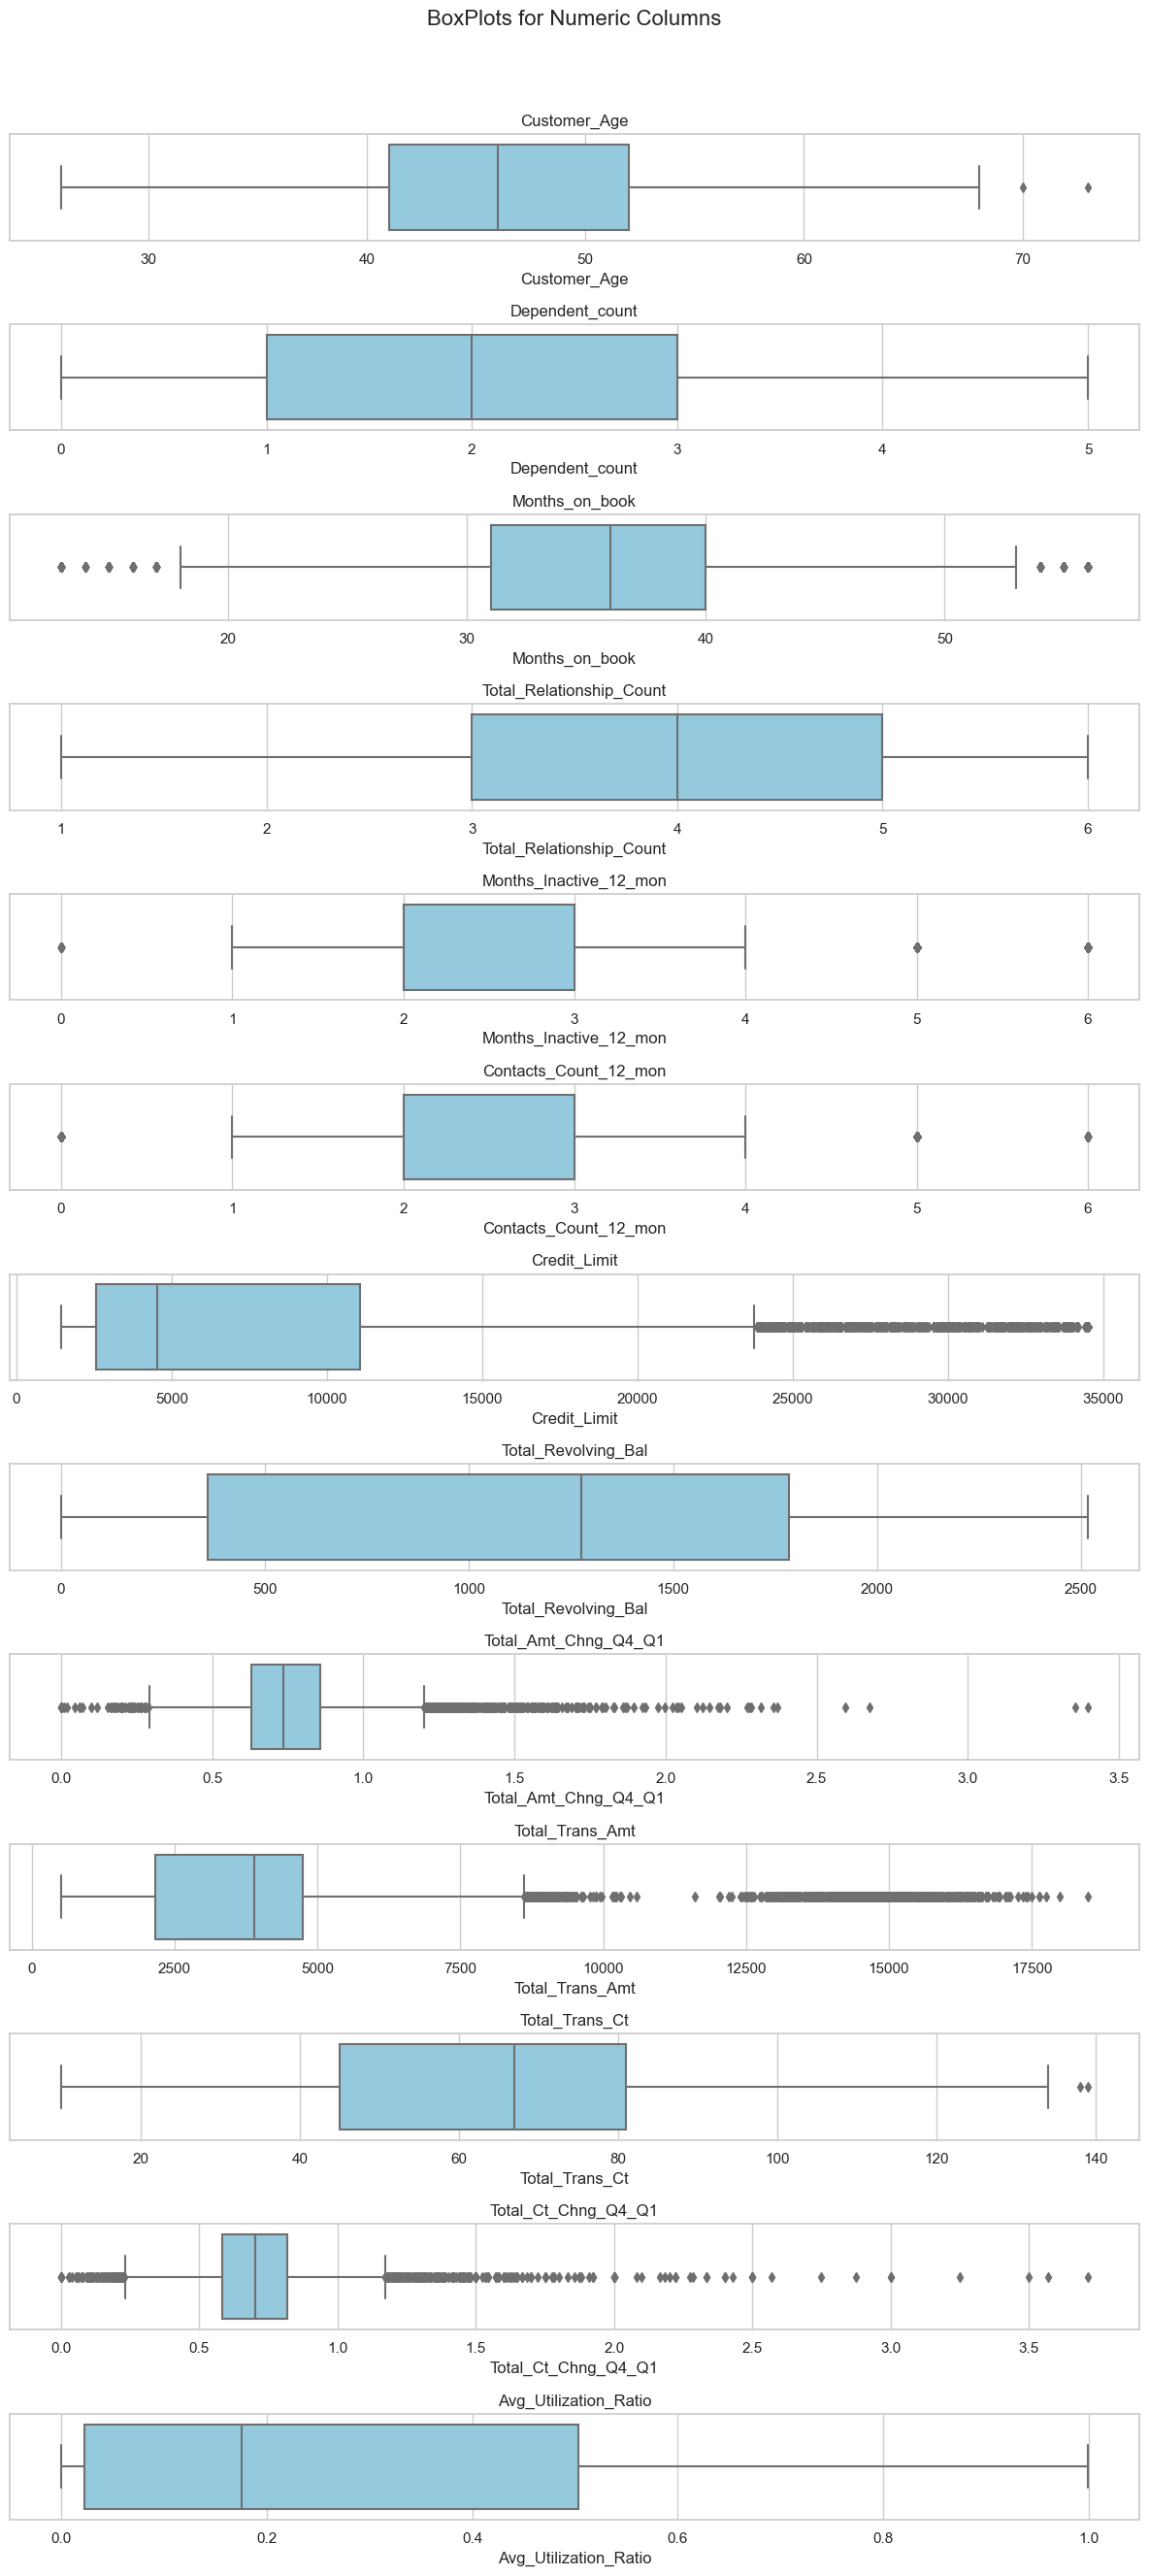

In [12]:
numeric_columns = [
    'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
    'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'
]

# Create subplots with adjusted horizontal length
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(12, 2*len(numeric_columns)))

# Add a title
fig.suptitle("BoxPlots for Numeric Columns", y=1.02, fontsize=16)

# Create boxplots for each numeric column
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)

# Adjust layout
plt.tight_layout()
plt.show()


### Some columns seem to have a lot of outliers. These columns are:
- #### Credit_Limit
- #### Total_Amt_Chng_Q4_Q1
- #### Total_Trans_Amt
- #### Total_Ct_Chng_Q4_Q1

<!-- ### All of these are skewed to the right. Thus, modified Zscore and IQR methods will be main used to detect outliers. -->

## Outlier Detection

In [13]:
# Get the outliers of each of the columns with each method.
Credit_Limit_outliers_z = find_outliers_zscore('Credit_Limit', df)
Total_Amt_Chng_Q4_Q1_outliers_z = find_outliers_zscore('Total_Amt_Chng_Q4_Q1', df)
Total_Trans_Amt_outliers_z = find_outliers_zscore('Total_Trans_Amt', df)
Total_Ct_Chng_Q4_Q1_outliers_z = find_outliers_zscore('Total_Ct_Chng_Q4_Q1', df)

Credit_Limit_outliers_modz = find_outliers_modified_zscore('Credit_Limit', df)
Total_Amt_Chng_Q4_Q1_outliers_modz = find_outliers_modified_zscore('Total_Amt_Chng_Q4_Q1', df)
Total_Trans_Amt_outliers_modz = find_outliers_modified_zscore('Total_Trans_Amt', df)
Total_Ct_Chng_Q4_Q1_outliers_modz = find_outliers_modified_zscore('Total_Ct_Chng_Q4_Q1', df)

Credit_Limit_outliers_iqr = find_outliers_iqr('Credit_Limit', df)
Total_Amt_Chng_Q4_Q1_outliers_iqr = find_outliers_iqr('Total_Amt_Chng_Q4_Q1', df)
Total_Trans_Amt_outliers_iqr = find_outliers_iqr('Total_Trans_Amt', df)
Total_Ct_Chng_Q4_Q1_outliers_iqr = find_outliers_iqr('Total_Ct_Chng_Q4_Q1', df)


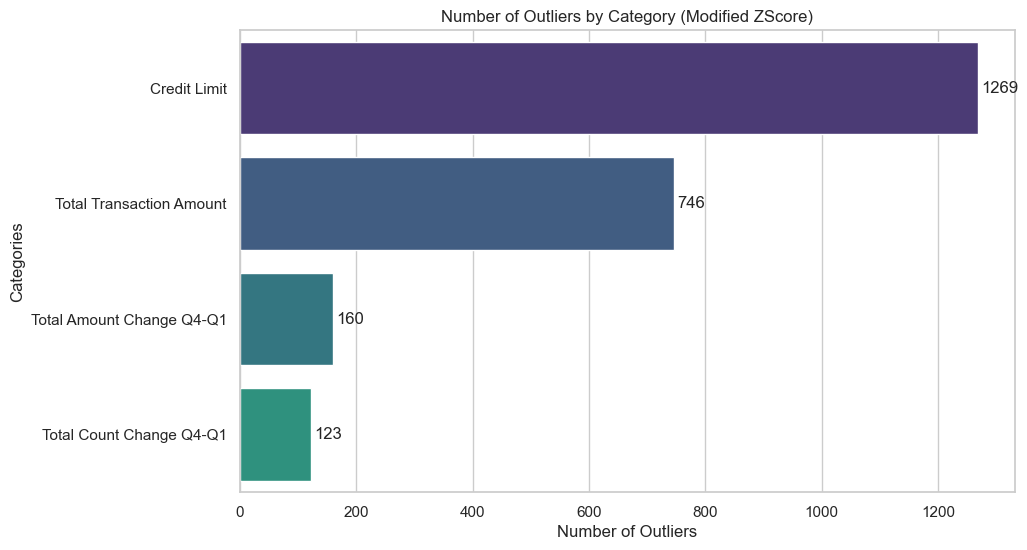

In [14]:
# Outlier counts using modified Zscore.
outlier_counts_modz = [
    Credit_Limit_outliers_modz.shape[0],
    Total_Amt_Chng_Q4_Q1_outliers_modz.shape[0],
    Total_Trans_Amt_outliers_modz.shape[0],
    Total_Ct_Chng_Q4_Q1_outliers_modz.shape[0]
]

categories_modz = ['Credit Limit', 'Total Amount Change Q4-Q1', 'Total Transaction Amount', 'Total Count Change Q4-Q1']

# Sort categories and outlier counts in descending order
sorted_data_modz = sorted(zip(categories_modz, outlier_counts_modz), key=lambda x: x[1], reverse=True)
sorted_categories_modz, sorted_outlier_counts_modz = zip(*sorted_data_modz)

# Create a DataFrame
data_df_modz = pd.DataFrame({'Categories': sorted_categories_modz, 'Number of Outliers': sorted_outlier_counts_modz})

# Customization
sns.set(style="whitegrid")
sns.set_palette("viridis")

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
bars_modz = sns.barplot(x='Number of Outliers', y='Categories', data=data_df_modz)

# Add data values on the bars
for bar, value in zip(bars_modz.patches, sorted_outlier_counts_modz):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, str(value), va='center')

plt.title('Number of Outliers by Category (Modified ZScore)')
plt.xlabel('Number of Outliers')
plt.ylabel('Categories')
plt.show()

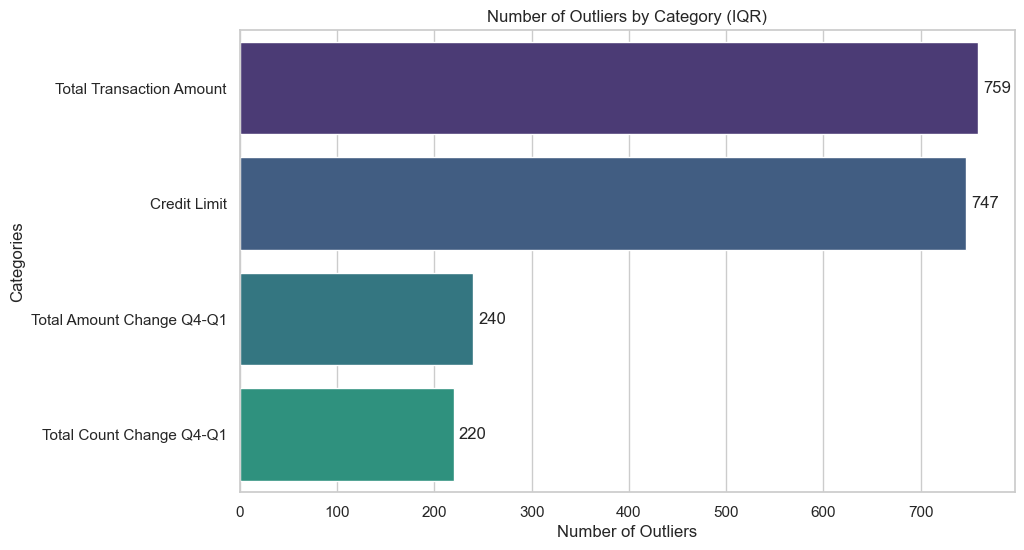

In [15]:
# Outlier counts using IQR
outlier_counts_iqr = [
    Credit_Limit_outliers_iqr.shape[0],
    Total_Amt_Chng_Q4_Q1_outliers_iqr.shape[0],
    Total_Trans_Amt_outliers_iqr.shape[0],
    Total_Ct_Chng_Q4_Q1_outliers_iqr.shape[0]
]

categories_iqr = ['Credit Limit', 'Total Amount Change Q4-Q1', 'Total Transaction Amount', 'Total Count Change Q4-Q1']

# Sort categories and outlier counts in descending order
sorted_data_iqr = sorted(zip(categories_iqr, outlier_counts_iqr), key=lambda x: x[1], reverse=True)
sorted_categories_iqr, sorted_outlier_counts_iqr = zip(*sorted_data_iqr)

# Create a DataFrame
data_df_iqr = pd.DataFrame({'Categories': sorted_categories_iqr, 'Number of Outliers': sorted_outlier_counts_iqr})

# Customization
sns.set(style="whitegrid")
sns.set_palette("viridis")

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Number of Outliers', y='Categories', data=data_df_iqr)

# Add data values on the bars
for bar, value in zip(bars.patches, sorted_outlier_counts_iqr):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, str(value), va='center')

plt.title('Number of Outliers by Category (IQR)')
plt.xlabel('Number of Outliers')
plt.ylabel('Categories')
plt.show()

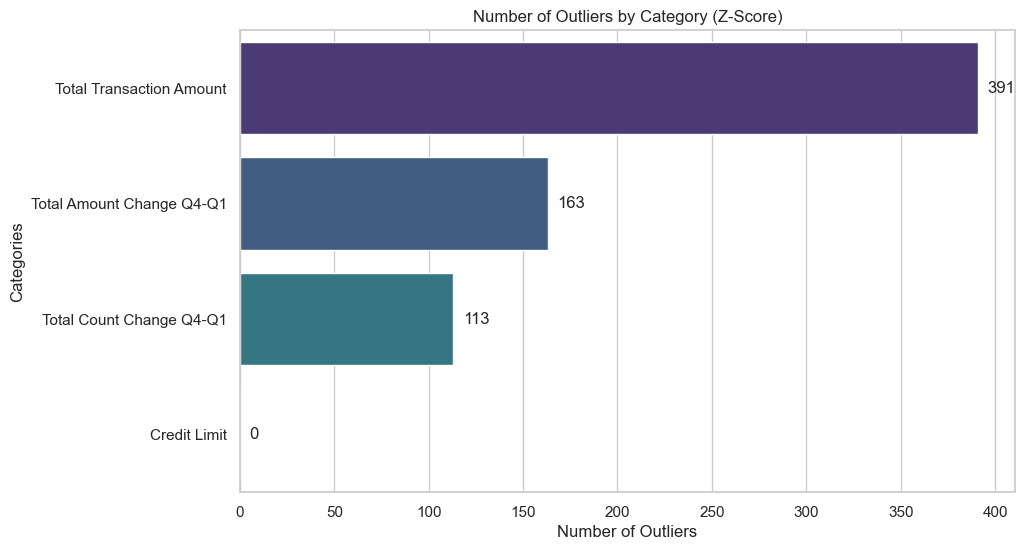

In [16]:
# Outlier counts using Zscore.
outlier_counts_z = [
    Credit_Limit_outliers_z.shape[0],
    Total_Amt_Chng_Q4_Q1_outliers_z.shape[0],
    Total_Trans_Amt_outliers_z.shape[0],
    Total_Ct_Chng_Q4_Q1_outliers_z.shape[0]
]

categories_z = ['Credit Limit', 'Total Amount Change Q4-Q1', 'Total Transaction Amount', 'Total Count Change Q4-Q1']

# Sort categories and outlier counts in descending order
sorted_data_z = sorted(zip(categories_z, outlier_counts_z), key=lambda x: x[1], reverse=True)
sorted_categories_z, sorted_outlier_counts_z = zip(*sorted_data_z)

# Create a DataFrame
data_df_z = pd.DataFrame({'Categories': sorted_categories_z, 'Number of Outliers': sorted_outlier_counts_z})

# Customization
sns.set(style="whitegrid")
sns.set_palette("viridis")

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Number of Outliers', y='Categories', data=data_df_z)

# Add data values on the bars
for bar, value in zip(bars.patches, sorted_outlier_counts_z):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, str(value), va='center')

plt.title('Number of Outliers by Category (Z-Score)')
plt.xlabel('Number of Outliers')
plt.ylabel('Categories')
plt.show()

# Biviariate Analysis

In [17]:
outlier_columns = ['Credit_Limit','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Ct_Chng_Q4_Q1']

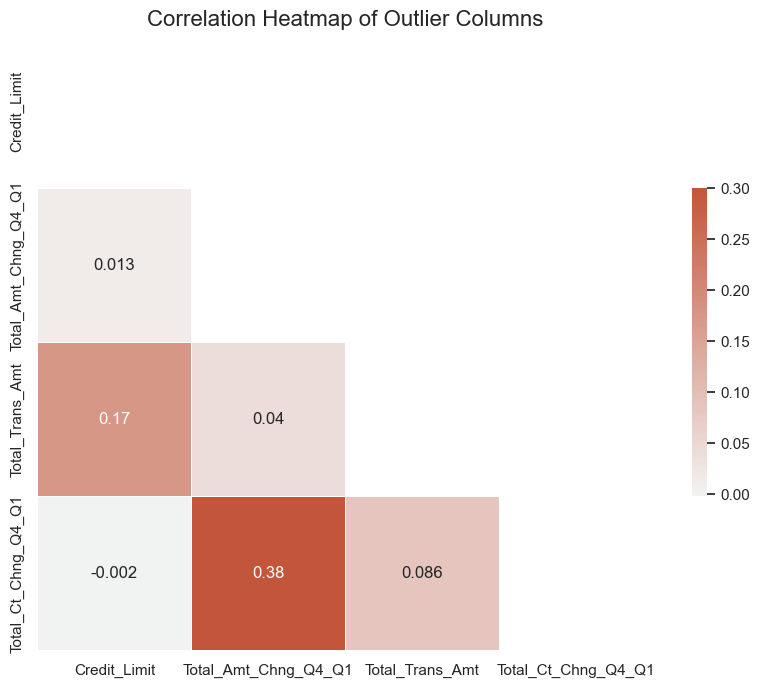

In [18]:
# Create a correlation matrix for these columns.
sns.set(style="white") 

corr_matrix = df[outlier_columns].corr()

plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Heatmap of Outlier Columns', fontsize=16)
plt.show()

c:\Users\con41\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\con41\AppData\Local\Temp\ipykernel_14704\3817945111.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


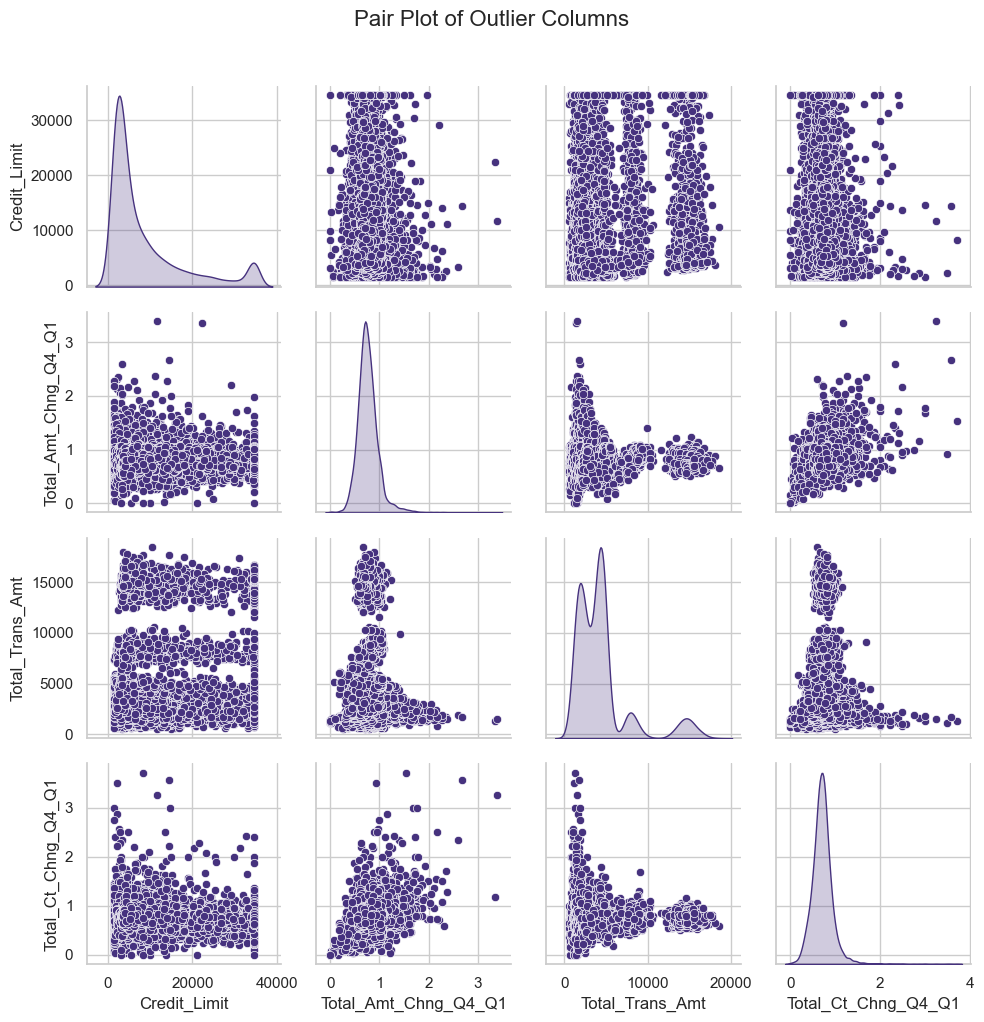

In [19]:
# Create a pairplot for outlier columns
sns.set(style="whitegrid")
sns.set_palette("viridis")

pair_plot = sns.pairplot(df[outlier_columns], markers="o", diag_kind="kde", height=2.5)

pair_plot.fig.suptitle("Pair Plot of Outlier Columns", y=1.02, fontsize=16)

plt.tight_layout()
plt.show()

### The function below was used to get a good idea of which columns had common and non common outliers. However, a lot of this analysis was removed to reduce reading time. Final results are at the end of the sector.

In [20]:
common, non_common = get_common_outliers(Credit_Limit_outliers_modz, Total_Amt_Chng_Q4_Q1_outliers_modz, df)

## Isolation Forest

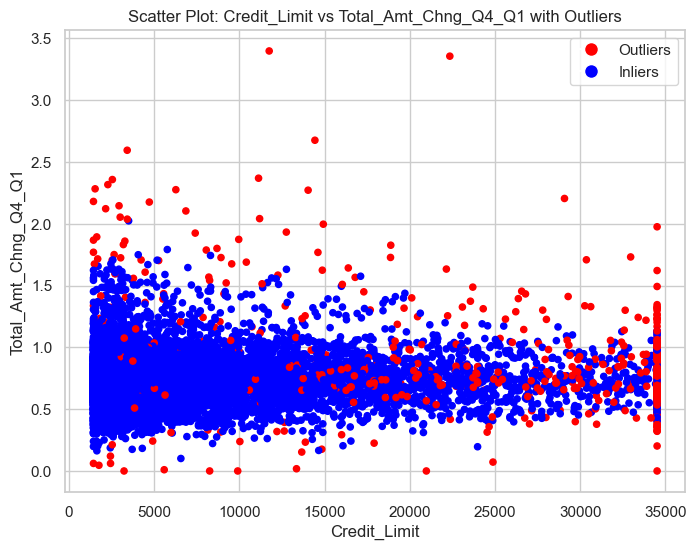

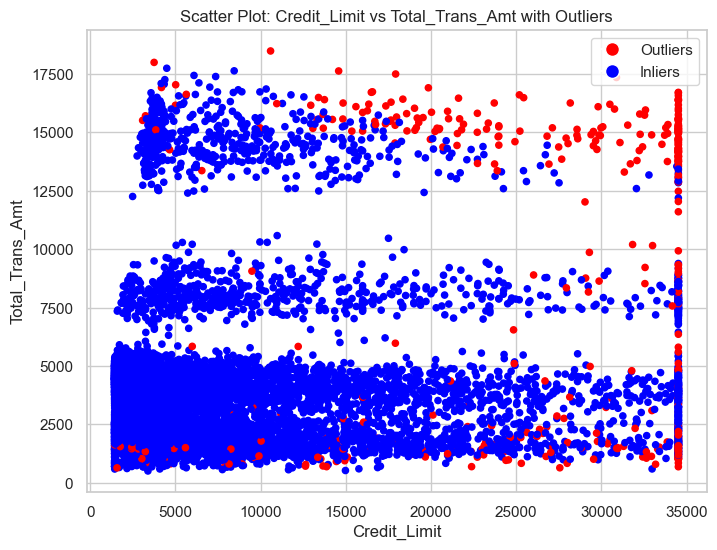

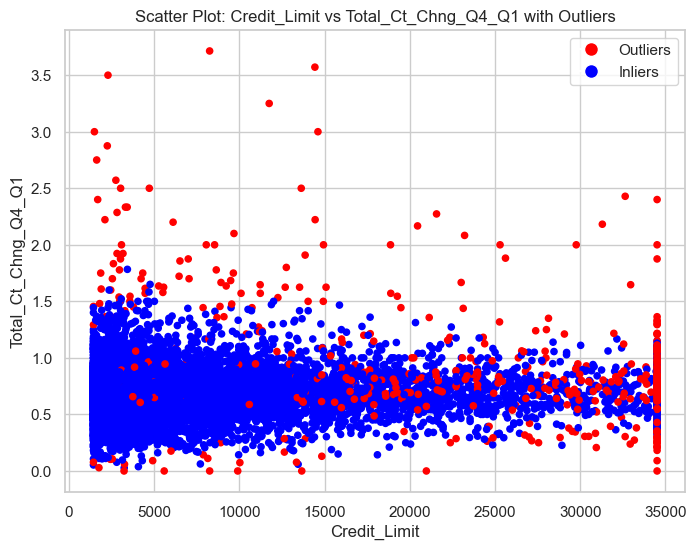

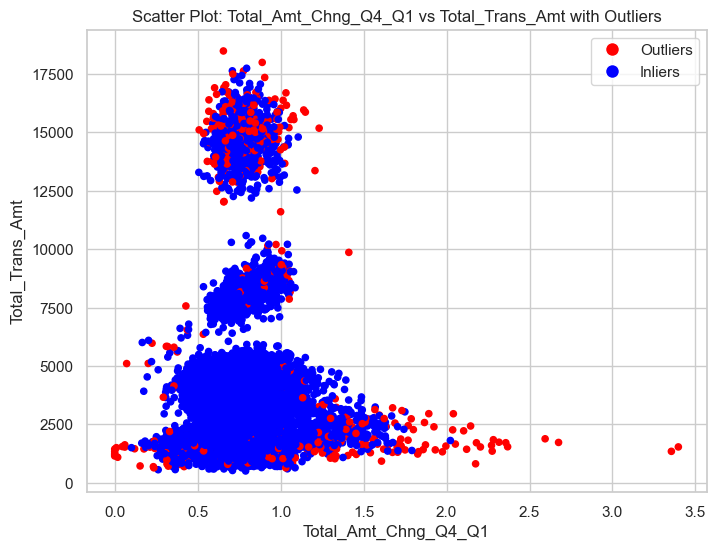

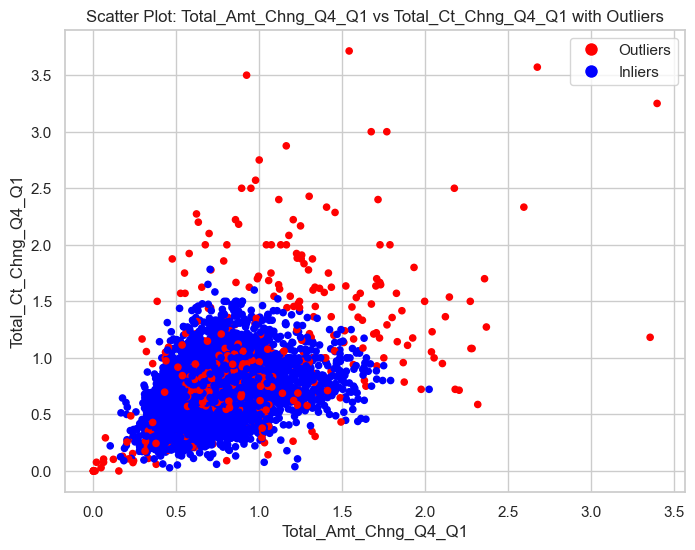

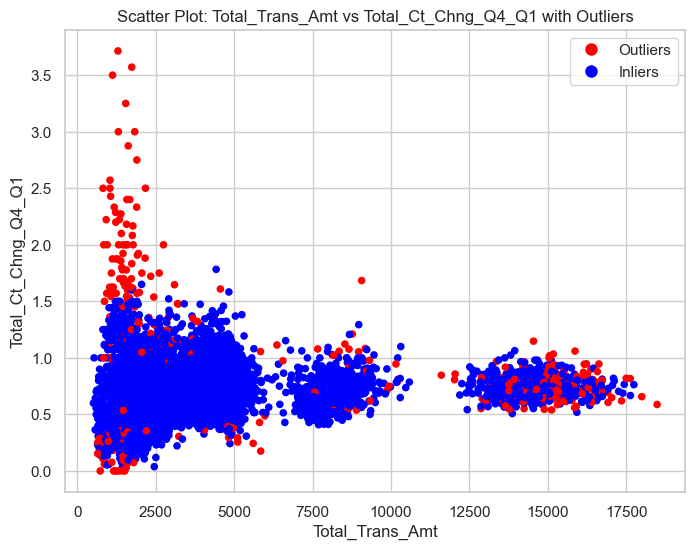

In [21]:
clf = IsolationForest(contamination=0.05)
clf.fit(df[outlier_columns])

# Predict outliers in the dataset
y_pred = clf.predict(df[outlier_columns])

# Create scatter plots for each pair of columns
for i in range(len(outlier_columns)):
    for j in range(i + 1, len(outlier_columns)):
        plt.figure(figsize=(8, 6))
        
        # Plot outliers in red and inliers in blue
        plt.scatter(df[outlier_columns[i]], df[outlier_columns[j]], c=np.where(y_pred == -1, 'red', 'blue'), s=20, label='Data Points')
        
        plt.title(f"Scatter Plot: {outlier_columns[i]} vs {outlier_columns[j]} with Outliers")
        plt.xlabel(outlier_columns[i])
        plt.ylabel(outlier_columns[j])
        
        # Add legend with custom labels and colors
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Outliers'),
                           Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inliers')]
        
        plt.legend(handles=legend_elements, loc='upper right')
        
        plt.show()

### Below is the code used to drop the outliers detected by the above methods. However, analysis was better if these rows were not removed from the DataFrame.

In [22]:
# from itertools import chain

# # Create a list to store all the indices we will drop
# outlier_indices = []

# # Get Isolation Forest outliers and store them in the list
# isolationforest_outliers = np.where(y_pred == -1)[0]
# outlier_indices.append(isolationforest_outliers)

# # Get credit limit outliers and store them in the list
# common_credit_limit, _ = get_common_outliers(Credit_Limit_outliers_iqr, Credit_Limit_outliers_modz)
# outlier_indices.append(list(common_credit_limit.index))

# common_total_amt_change, _ = get_common_outliers(Total_Amt_Chng_Q4_Q1_outliers_modz, Total_Amt_Chng_Q4_Q1_outliers_iqr)
# outlier_indices.append(list(common_total_amt_change.index))

# common_trans_amt, _ = get_common_outliers(Total_Trans_Amt_outliers_modz, Total_Trans_Amt_outliers_iqr)
# outlier_indices.append(list(common_total_amt_change.index))



# # Flattening the list into a set to drop duplicates and then back
# outliers = set(chain(*outlier_indices))
# outliers_to_drop = list(outliers)

# df.drop(outliers_to_drop,inplace=True)

# df.to_csv('No_outliers.csv', index=False, mode='w')